In [35]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import optax
import gymnasium as gym
import numpy as np
import random


In [36]:

class QNetwork(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(64)(x)
        x = nn.relu(x)
        x = nn.Dense(64)(x)
        x = nn.relu(x)
        x = nn.Dense(2)(x)
        return x

class EnvModel(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(64)(x)
        x = nn.relu(x)
        x = nn.Dense(64)(x)
        x = nn.relu(x)
        x = nn.Dense(5)(x)  # 4 for next state, 1 for reward
        return x


In [37]:
# Hyperparameters
learning_rate = 1e-3
gamma = 0.99
epsilon = 1.0
epsilon_decay = 0.995
episodes = 500
batch_size = 64
planning_steps = 10

env = gym.make("CartPole-v1",render_mode='rgb_array').env
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

q_network = QNetwork()
env_model = EnvModel()

params = q_network.init(jax.random.PRNGKey(0), jnp.zeros((state_dim,)))
env_model_params = env_model.init(jax.random.PRNGKey(1), jnp.zeros((state_dim + 1,)))

optimizer = optax.adam(learning_rate)
env_model_optimizer = optax.adam(learning_rate)

opt_state = optimizer.init(params)
env_model_opt_state = env_model_optimizer.init(env_model_params)

@jax.jit
def q_learning_update(params, opt_state, state, action, reward, next_state, done):
    def loss_fn(params):
        q_values = q_network.apply(params, state)
        next_q_values = q_network.apply(params, next_state)
        target = reward + gamma * jnp.max(next_q_values, axis=1) * (1 - done)
        loss = jnp.mean((q_values[jnp.arange(q_values.shape[0]), action] - target) ** 2)
        return loss

    loss, grads = jax.value_and_grad(loss_fn)(params)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state
 
@jax.jit
def env_model_update(env_model_params, env_model_opt_state, state, action, next_state, reward):
    def env_model_loss_fn(env_model_params):

        state_action = jnp.hstack([state, action.reshape(-1,1)])#, axis=1
        predictions = env_model.apply(env_model_params, state_action)
        target = jnp.concatenate([next_state, reward.reshape(-1,1)], axis=1)
        env_model_loss = jnp.mean(jnp.square(predictions - target))
        return env_model_loss

    env_model_loss, env_model_grads = jax.value_and_grad(env_model_loss_fn)(env_model_params)
    env_model_updates, env_model_opt_state = env_model_optimizer.update(env_model_grads, env_model_opt_state)
    env_model_params = optax.apply_updates(env_model_params, env_model_updates)
    return env_model_params, env_model_opt_state

memory = []
reward_history = []
max_episode_steps = 200
reward_threshold=175 # env.spec.reward_threshold
solved_window = 100

for episode in range(episodes):
    state, _ = env.reset()
    done = False
    total_reward = 0
    step_in_episode = 0

    while not done:
        if random.random() < epsilon:
            action = env.action_space.sample()
        else:
            q_values = q_network.apply(params, jnp.expand_dims(jnp.array(state), axis=0))
            action = jnp.argmax(q_values).item()

        next_state, reward, done, _, _ = env.step(action)

        memory.append((state, action, reward, next_state, done))
        state = next_state
        total_reward += reward
        step_in_episode += 1

        if len(memory) >= batch_size:
            batch = random.sample(memory, batch_size)

            state_batch = jnp.array([s for (s, _, _, _, _) in batch])
            action_batch = jnp.array([a for (_, a, _, _, _) in batch])
            reward_batch = jnp.array([r for (_, _, r, _, _) in batch])
            next_state_batch = jnp.array([ns for (_, _, _, ns, _) in batch])
            done_batch = jnp.array([d for (_, _, _, _, d) in batch], dtype=jnp.float32)

            params, opt_state = q_learning_update(params, opt_state, state_batch, action_batch, reward_batch, next_state_batch, done_batch)
            env_model_params, env_model_opt_state = env_model_update(env_model_params, env_model_opt_state, state_batch, action_batch, next_state_batch, reward_batch)

            for _ in range(planning_steps):
                planning_batch = random.sample(memory, batch_size)

                state_batch = jnp.array([s for (s, _, _, _, _) in planning_batch])
                action_batch = jnp.array([a for (_, a, _, _, _) in batch])

                state_action_batch = jnp.concatenate([state_batch, action_batch[:, np.newaxis]], axis=1)
                predictions = env_model.apply(env_model_params, state_action_batch)
                next_state_batch, reward_batch = predictions[:, :4], predictions[:, 4]
                done_batch = (jnp.abs(jnp.sum(next_state_batch - state_batch, axis=1)) > 0.5).astype(jnp.float32)

                params, opt_state = q_learning_update(params, opt_state, state_batch, action_batch, reward_batch, next_state_batch, done_batch)
        
        # episode stopping
        # check if the max_episode_steps are met. if so, terminate this episode
        if step_in_episode >= max_episode_steps:
            print(f"Agent reached max_episode_steps in episode {episode}.")
            break

    epsilon = max(epsilon * epsilon_decay, 0.01)
    print(f"Episode {episode + 1}, Total Reward: {total_reward}")

    # outputs
    reward_history.append(total_reward)

    # stop training if average reward reaches requirement
    # Calculate the average reward over the last 'solved_window' episodes
    if episode >= solved_window:
        avg_reward = np.mean(reward_history[-solved_window:])
        print(f'Episode: {episode}, Average Reward: {avg_reward}')

        if avg_reward >= reward_threshold:
            print(f"CartPole-v1 solved in {episode} episodes!")
            break



Episode 1, Total Reward: 12.0
Episode 2, Total Reward: 10.0
Episode 3, Total Reward: 11.0
Episode 4, Total Reward: 11.0
Episode 5, Total Reward: 31.0
Episode 6, Total Reward: 20.0
Episode 7, Total Reward: 23.0
Episode 8, Total Reward: 15.0
Episode 9, Total Reward: 56.0
Episode 10, Total Reward: 9.0
Episode 11, Total Reward: 15.0
Episode 12, Total Reward: 28.0
Episode 13, Total Reward: 11.0
Episode 14, Total Reward: 15.0
Episode 15, Total Reward: 17.0
Episode 16, Total Reward: 23.0
Episode 17, Total Reward: 24.0
Episode 18, Total Reward: 18.0
Episode 19, Total Reward: 21.0
Episode 20, Total Reward: 51.0
Episode 21, Total Reward: 9.0
Episode 22, Total Reward: 47.0
Episode 23, Total Reward: 24.0
Episode 24, Total Reward: 23.0
Episode 25, Total Reward: 13.0
Episode 26, Total Reward: 18.0
Episode 27, Total Reward: 16.0
Episode 28, Total Reward: 41.0
Episode 29, Total Reward: 27.0
Episode 30, Total Reward: 16.0
Episode 31, Total Reward: 11.0
Episode 32, Total Reward: 24.0
Episode 33, Total R

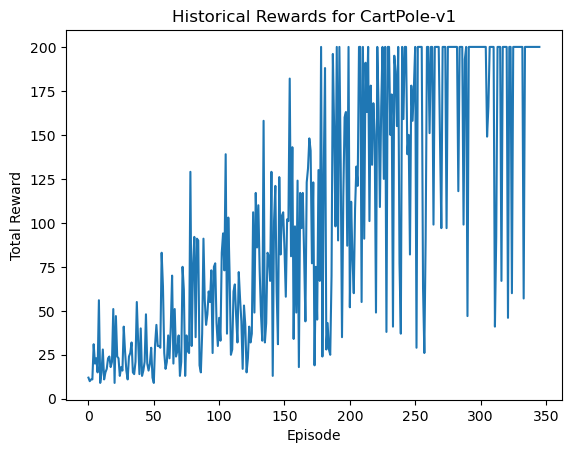

In [38]:
import matplotlib.pyplot as plt
# Plot the historical rewards
plt.plot(reward_history)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Historical Rewards for CartPole-v1")
plt.show()

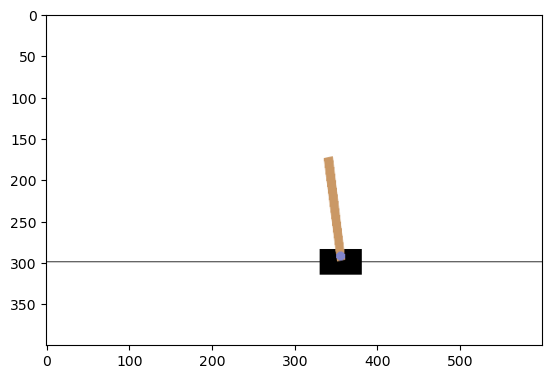

Agent reached max_episode_steps in episode 345.
Total Reward: 200.0


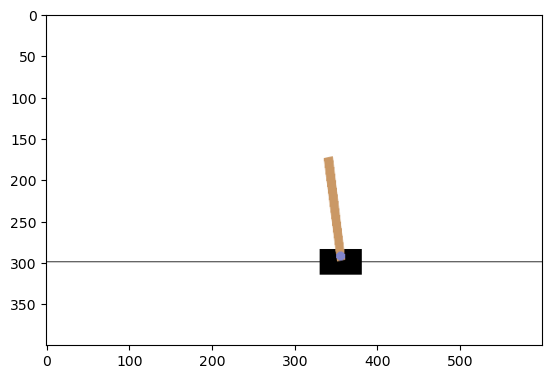

In [43]:
# need a virtual display for rendering in docker
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()
from IPython import display as ipythondisplay

# Test the trained agent

print("\nTesting the trained agent...")
env = gym.make("CartPole-v1",render_mode='rgb_array').env
state, _ = env.reset()
state = jnp.array(state, dtype=jnp.float32)

total_reward = 0
done = False
pre_screen = env.render()
step_in_episode = 0

while not done:
    q_values = q_network.apply(params, jnp.expand_dims(jnp.array(state), axis=0))
    action = jnp.argmax(q_values).item()
    #action = agent.act(state)
    next_state, reward, done, _, _ = env.step(action)
    next_state = jnp.array(next_state, dtype=jnp.float32)
    screen = env.render()
    state = next_state
    total_reward += reward
    step_in_episode += 1

    plt.imshow(screen)
    ipythondisplay.clear_output(wait=True)
    ipythondisplay.display(plt.gcf())

    # check if the max_episode_steps are met. if so, terminate this episode
    if step_in_episode >= max_episode_steps:
        print(f"Agent reached max_episode_steps in test.")
        break

    ipythondisplay.clear_output(wait=True)
    
print(f"Total Reward: {total_reward}")

env.close()


In [41]:
print(pre_screen)

None
